In [2]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
from sklearn.decomposition import TruncatedSVD
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_auc_score)
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

In [3]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("../data/df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "../data/coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [4]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [5]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [6]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [7]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [8]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


### Data Prep

In [9]:
all_stations = ['ILL13', 'ILL12', 'ILL16', 'ILL18', 'ILL17', 'ILL11']

print(f"  Stations: {all_stations}")

# Create wide format with ALL stations
df_wide_all = df_june.pivot(
    index='time_minute',
    columns='station',
    values='anomaly_score'
)[all_stations]

# Fill missing values
df_wide_all_filled = df_wide_all.fillna(method='ffill').fillna(method='bfill')

print(f"  Data shape: {df_wide_all_filled.shape}")
print(f"  Time range: {df_wide_all_filled.index.min()} to {df_wide_all_filled.index.max()}")

# Get debris flow indicator
debris_flow_indicator = df_june.groupby('time_minute')['debris flow'].max()
debris_flow_indicator = debris_flow_indicator.reindex(df_wide_all_filled.index).fillna(0).astype(int)

print(f"  Debris flow timepoints: {debris_flow_indicator.sum()} / {len(debris_flow_indicator)}")


  Stations: ['ILL13', 'ILL12', 'ILL16', 'ILL18', 'ILL17', 'ILL11']
  Data shape: (43200, 6)
  Time range: 2020-06-01 00:00:00 to 2020-06-30 23:59:00
  Debris flow timepoints: 868 / 43200


In [10]:
# Standardize data
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(df_wide_all_filled)

print(f"  Scaled data shape: {all_data_scaled.shape}")
print(f"  Mean per station: {scaler.mean_}")
print(f"  Std per station: {scaler.scale_}")

FROZEN_SCALER_MEAN = scaler.mean_.copy()
FROZEN_SCALER_STD = scaler.scale_.copy()

  Scaled data shape: (43200, 6)
  Mean per station: [0.41791072 0.37959733 0.38233272 0.3879954  0.42475361 0.39941828]
  Std per station: [0.06553443 0.06030693 0.04296702 0.0660443  0.07590902 0.06384578]


### Temporal train test split

In [11]:
temporal_split_idx = int(len(df_wide_all_filled) * 0.8)

print(f"  Total timepoints: {len(df_wide_all_filled)}")
print(f"  Training: 0 to {temporal_split_idx}")
print(f"  Validation: {temporal_split_idx} to {len(df_wide_all_filled)}")

data_scaled_train = all_data_scaled[:temporal_split_idx, :]
data_scaled_val = all_data_scaled[temporal_split_idx:, :]

debris_train = debris_flow_indicator.values[:temporal_split_idx]
debris_val = debris_flow_indicator.values[temporal_split_idx:]

print(f"  Training debris flows: {debris_train.sum()}")
print(f"  Validation debris flows: {debris_val.sum()}")

  Total timepoints: 43200
  Training: 0 to 34560
  Validation: 34560 to 43200
  Training debris flows: 765
  Validation debris flows: 103


### Multitask Network Architecture

In [27]:
class MultiTaskDebrisFlowNet(nn.Module):
    def __init__(self, n_stations=6, lookback=110, hidden_size=64):
        super().__init__()
        
        # Shared LSTM encoder
        self.lstm = nn.LSTM(
            input_size=n_stations,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        # Task 1: Anomaly score prediction (regression)
        self.score_head = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, n_stations)
        )
        
        # Task 2: Debris flow detection (binary classification)
        self.detection_head = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(16, 1)
        )
        
        # Task 3: Flow head location (multi-class classification)
        self.location_head = nn.Sequential(
            nn.Linear(hidden_size, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, n_stations)
        )
    
    def forward(self, x):
        # Shared LSTM encoding
        lstm_out, _ = self.lstm(x)
        encoding = lstm_out[:, -1, :]  # Last timestep: (batch, hidden_size)
        
        # Task 1: Predicted anomaly scores
        pred_scores = self.score_head(encoding)  # (batch, 6)
        
        # Task 2: Debris flow detection (logits, will apply sigmoid in loss)
        pred_active_logits = self.detection_head(encoding)  # (batch, 1)
        
        # Task 3: Flow head location (logits, will apply softmax in loss)
        pred_location_logits = self.location_head(encoding)  # (batch, 6)
        
        return pred_scores, pred_active_logits, pred_location_logits

print("  Architecture:")
print("    Shared LSTM: (6 stations, 110 timesteps) → 64 hidden units")
print("    Task 1 (Scores): 64 → 32 → 6 outputs (regression)")
print("    Task 2 (Detection): 64 → 16 → 1 output (binary classification)")
print("    Task 3 (Location): 64 → 16 → 6 outputs (multi-class classification)")


  Architecture:
    Shared LSTM: (6 stations, 110 timesteps) → 64 hidden units
    Task 1 (Scores): 64 → 32 → 6 outputs (regression)
    Task 2 (Detection): 64 → 16 → 1 output (binary classification)
    Task 3 (Location): 64 → 16 → 6 outputs (multi-class classification)


In [28]:
class MultiTaskDataset(Dataset):
    def __init__(self, data, debris_indicator, lookback_start=120, lookback_end=10):
        self.data = data  # (n_timepoints, n_stations) - scaled
        self.debris = debris_indicator  # (n_timepoints,) - binary
        self.lookback_start = lookback_start
        self.lookback_end = lookback_end
        self.lookback = lookback_start - lookback_end  # 110 minutes
    
    def __len__(self):
        return len(self.data) - self.lookback_start
    
    def __getitem__(self, idx):
        # Input: window from [t-30 : t-10]
        t = idx + self.lookback_start
        input_window = self.data[t - self.lookback_start : t - self.lookback_end]
        
        # Task 1 target: Anomaly scores at time t
        target_scores = self.data[t]  # (6,)
        
        # Task 2 target: Debris flow active at time t
        target_active = float(self.debris[t])  # Binary: 0 or 1
        
        # Task 3 target: Which station has max score at time t
        max_station_idx = np.argmax(self.data[t])  # Index of max station
        
        return (
            torch.FloatTensor(input_window),  # (110, 6)
            torch.FloatTensor(target_scores),  # (6,)
            torch.FloatTensor([target_active]),  # (1,)
            torch.LongTensor([max_station_idx])  # (1,) - class index
        )

lookback_start = 30
lookback_end = 10
lookback = lookback_start - lookback_end

train_dataset = MultiTaskDataset(data_scaled_train, debris_train, lookback_start, lookback_end)
val_dataset = MultiTaskDataset(data_scaled_val, debris_val, lookback_start, lookback_end)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"  Lookback window: [t-{lookback_start}, t-{lookback_end}] = {lookback} minutes")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")

  Lookback window: [t-30, t-10] = 20 minutes
  Train dataset size: 34530
  Validation dataset size: 8610


### Loss Functions and Training

In [29]:
model = MultiTaskDebrisFlowNet(n_stations=len(all_stations), lookback=lookback, hidden_size=64)

# Loss functions
criterion_regression = nn.MSELoss()
criterion_detection = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([9.0]))  # Class imbalance
criterion_location = nn.CrossEntropyLoss(reduction='none')  # Will mask manually

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Loss weights
alpha = 1.0  # Regression
beta = 1.0   # Detection
gamma = 5.0  # Location

print(f"  Loss weights: α={alpha} (regression), β={beta} (detection), γ={gamma} (location)")
print(f"  Detection loss: BCEWithLogits with pos_weight=9.0 (class imbalance)")
print(f"  Location loss: CrossEntropy (masked to debris flow times only)")

  Loss weights: α=1.0 (regression), β=1.0 (detection), γ=5.0 (location)
  Detection loss: BCEWithLogits with pos_weight=9.0 (class imbalance)
  Location loss: CrossEntropy (masked to debris flow times only)


In [ ]:
n_epochs = 50
best_val_loss = float('inf')
best_model_state = None

train_losses = {'total': [], 'regression': [], 'detection': [], 'location': []}
val_losses = {'total': [], 'regression': [], 'detection': [], 'location': []}

for epoch in range(n_epochs):
    # Training
    model.train()
    train_loss_total = 0
    train_loss_reg = 0
    train_loss_det = 0
    train_loss_loc = 0
    
    for input_window, target_scores, target_active, target_location in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        pred_scores, pred_active_logits, pred_location_logits = model(input_window)
        
        # Task 1: Regression loss
        loss_reg = criterion_regression(pred_scores, target_scores)
        
        # Task 2: Detection loss
        loss_det = criterion_detection(pred_active_logits, target_active)
        
        # Task 3: Location loss (masked by debris flow presence)
        loss_loc_unmasked = criterion_location(pred_location_logits, target_location.squeeze())
        mask = target_active.squeeze() > 0.5  # Only where debris flow is active
        if mask.sum() > 0:
            loss_loc = loss_loc_unmasked[mask].mean()
        else:
            loss_loc = torch.tensor(0.0)
        
        # Combined loss
        total_loss = alpha * loss_reg + beta * loss_det + gamma * loss_loc
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        train_loss_total += total_loss.item()
        train_loss_reg += loss_reg.item()
        train_loss_det += loss_det.item()
        train_loss_loc += loss_loc.item() if isinstance(loss_loc, torch.Tensor) else loss_loc
    
    train_loss_total /= len(train_loader)
    train_loss_reg /= len(train_loader)
    train_loss_det /= len(train_loader)
    train_loss_loc /= len(train_loader)
    
    train_losses['total'].append(train_loss_total)
    train_losses['regression'].append(train_loss_reg)
    train_losses['detection'].append(train_loss_det)
    train_losses['location'].append(train_loss_loc)
    
    # Validation
    model.eval()
    val_loss_total = 0
    val_loss_reg = 0
    val_loss_det = 0
    val_loss_loc = 0
    
    with torch.no_grad():
        for input_window, target_scores, target_active, target_location in val_loader:
            pred_scores, pred_active_logits, pred_location_logits = model(input_window)
            
            loss_reg = criterion_regression(pred_scores, target_scores)
            loss_det = criterion_detection(pred_active_logits, target_active)
            
            loss_loc_unmasked = criterion_location(pred_location_logits, target_location.squeeze())
            mask = target_active.squeeze() > 0.5
            if mask.sum() > 0:
                loss_loc = loss_loc_unmasked[mask].mean()
            else:
                loss_loc = torch.tensor(0.0)
            
            total_loss = alpha * loss_reg + beta * loss_det + gamma * loss_loc
            
            val_loss_total += total_loss.item()
            val_loss_reg += loss_reg.item()
            val_loss_det += loss_det.item()
            val_loss_loc += loss_loc.item() if isinstance(loss_loc, torch.Tensor) else loss_loc
    
    val_loss_total /= len(val_loader)
    val_loss_reg /= len(val_loader)
    val_loss_det /= len(val_loader)
    val_loss_loc /= len(val_loader)
    
    val_losses['total'].append(val_loss_total)
    val_losses['regression'].append(val_loss_reg)
    val_losses['detection'].append(val_loss_det)
    val_losses['location'].append(val_loss_loc)
    
    # Save best model
    if val_loss_total < best_val_loss:
        best_val_loss = val_loss_total
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1}/{n_epochs}')
        print(f'    Train - Total: {train_loss_total:.4f} | Reg: {train_loss_reg:.4f} | Det: {train_loss_det:.4f} | Loc: {train_loss_loc:.4f}')
        print(f'    Val   - Total: {val_loss_total:.4f} | Reg: {val_loss_reg:.4f} | Det: {val_loss_det:.4f} | Loc: {val_loss_loc:.4f}')

model.load_state_dict(best_model_state)

print(f"  Training complete")
print(f"  Best validation total loss: {best_val_loss:.4f}")

# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(train_losses['total'], label='Train', linewidth=2)
axes[0, 0].plot(val_losses['total'], label='Val', linewidth=2)
axes[0, 0].set_title('Total Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(train_losses['regression'], label='Train', linewidth=2)
axes[0, 1].plot(val_losses['regression'], label='Val', linewidth=2)
axes[0, 1].set_title('Task 1: Regression Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MSE')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

axes[1, 0].plot(train_losses['detection'], label='Train', linewidth=2)
axes[1, 0].plot(val_losses['detection'], label='Val', linewidth=2)
axes[1, 0].set_title('Task 2: Detection Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('BCE')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(train_losses['location'], label='Train', linewidth=2)
axes[1, 1].plot(val_losses['location'], label='Val', linewidth=2)
axes[1, 1].set_title('Task 3: Location Loss', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('CrossEntropy')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.suptitle('Multi-Task Training Curves', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('multitask_training_curves.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: multitask_training_curves.png")
plt.show()


### Prediction

In [16]:
model.eval()
predictions_scores_val = []
predictions_active_val = []
predictions_location_val = []
actuals_scores_val = []
actuals_active_val = []
actuals_location_val = []

with torch.no_grad():
    for input_window, target_scores, target_active, target_location in val_loader:
        pred_scores, pred_active_logits, pred_location_logits = model(input_window)
        
        # Apply activations
        pred_active = torch.sigmoid(pred_active_logits)
        pred_location_probs = torch.softmax(pred_location_logits, dim=1)
        
        predictions_scores_val.append(pred_scores.numpy())
        predictions_active_val.append(pred_active.numpy())
        predictions_location_val.append(pred_location_probs.numpy())
        
        actuals_scores_val.append(target_scores.numpy())
        actuals_active_val.append(target_active.numpy())
        actuals_location_val.append(target_location.numpy())

predictions_scores_val = np.vstack(predictions_scores_val)  # (n_samples, 6)
predictions_active_val = np.vstack(predictions_active_val).squeeze()  # (n_samples,)
predictions_location_val = np.vstack(predictions_location_val)  # (n_samples, 6)

actuals_scores_val = np.vstack(actuals_scores_val)  # (n_samples, 6)
actuals_active_val = np.vstack(actuals_active_val).squeeze()  # (n_samples,)
actuals_location_val = np.vstack(actuals_location_val).squeeze()  # (n_samples,)

# Un-standardize scores
predictions_scores_val_unscaled = predictions_scores_val * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN
actuals_scores_val_unscaled = actuals_scores_val * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN

# Binary predictions for detection
predictions_active_binary = (predictions_active_val > 0.5).astype(int)

# Location predictions (argmax)
predictions_location_class = np.argmax(predictions_location_val, axis=1)

print(f"  Predictions shape:")
print(f"    Scores: {predictions_scores_val_unscaled.shape}")
print(f"    Detection: {predictions_active_val.shape}")
print(f"    Location: {predictions_location_val.shape}")

  Predictions shape:
    Scores: (8610, 6)
    Detection: (8610,)
    Location: (8610, 6)


### Evaluation

In [17]:
print("\n Evaluating Task 1: Anomaly Score Prediction")


# Overall metrics
rmse_overall = np.sqrt(mean_squared_error(actuals_scores_val_unscaled, predictions_scores_val_unscaled))
mae_overall = mean_absolute_error(actuals_scores_val_unscaled, predictions_scores_val_unscaled)
r2_overall = r2_score(actuals_scores_val_unscaled.flatten(), predictions_scores_val_unscaled.flatten())

print(f"\nOVERALL (All stations):")
print(f"  RMSE: {rmse_overall:.4f}")
print(f"  MAE:  {mae_overall:.4f}")
print(f"  R²:   {r2_overall:.4f}")

# Per-station metrics
print(f"\nPER-STATION:")
print(f"{'Station':<10} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
print("-" * 40)

for i, station in enumerate(all_stations):
    rmse_st = np.sqrt(mean_squared_error(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i]))
    mae_st = mean_absolute_error(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i])
    r2_st = r2_score(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i])
    
    print(f"{station:<10} {rmse_st:<10.4f} {mae_st:<10.4f} {r2_st:<10.4f}")


 Evaluating Task 1: Anomaly Score Prediction

OVERALL (All stations):
  RMSE: 0.0395
  MAE:  0.0218
  R²:   0.6871

PER-STATION:
Station    RMSE       MAE        R²        
----------------------------------------
ILL13      0.0233     0.0153     0.7909    
ILL12      0.0215     0.0127     0.7781    
ILL16      0.0333     0.0177     0.1898    
ILL18      0.0410     0.0244     0.4024    
ILL17      0.0713     0.0466     0.4886    
ILL11      0.0216     0.0141     0.8041    


In [18]:
print("\n Evaluating Task 2: Debris Flow Detection")

# Classification report
print("\nClassification Report:")
print(classification_report(actuals_active_val, predictions_active_binary, 
                          target_names=['No Flow', 'Debris Flow'], digits=4))

# Confusion matrix
cm = confusion_matrix(actuals_active_val, predictions_active_binary)
print("\nConfusion Matrix:")
print(f"                Predicted No Flow  Predicted Debris Flow")
print(f"Actual No Flow        {cm[0,0]:5d}              {cm[0,1]:5d}")
print(f"Actual Debris Flow    {cm[1,0]:5d}              {cm[1,1]:5d}")

# Additional metrics
precision = precision_score(actuals_active_val, predictions_active_binary)
recall = recall_score(actuals_active_val, predictions_active_binary)
f1 = f1_score(actuals_active_val, predictions_active_binary)
roc_auc = roc_auc_score(actuals_active_val, predictions_active_val)

print(f"\nMetrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")



 Evaluating Task 2: Debris Flow Detection

Classification Report:
              precision    recall  f1-score   support

     No Flow     0.9972    0.9966    0.9969      8507
 Debris Flow     0.7315    0.7670    0.7488       103

    accuracy                         0.9938      8610
   macro avg     0.8643    0.8818    0.8728      8610
weighted avg     0.9940    0.9938    0.9939      8610


Confusion Matrix:
                Predicted No Flow  Predicted Debris Flow
Actual No Flow         8478                 29
Actual Debris Flow       24                 79

Metrics:
  Precision: 0.7315
  Recall:    0.7670
  F1 Score:  0.7488
  ROC-AUC:   0.8817


In [19]:
# Only evaluate when debris flow is actually active
debris_mask = actuals_active_val == 1

if debris_mask.sum() > 0:
    # Accuracy: predicted station = actual max station
    correct = (predictions_location_class[debris_mask] == actuals_location_val[debris_mask])
    accuracy = correct.mean()
    
    # Top-2 accuracy: actual max in top 2 predictions
    top2_predictions = np.argsort(predictions_location_val[debris_mask], axis=1)[:, -2:]
    top2_correct = np.array([actuals_location_val[debris_mask][i] in top2_predictions[i] 
                             for i in range(len(top2_predictions))])
    top2_accuracy = top2_correct.mean()
    
    print(f"\nLocation Prediction (during debris flows only, n={debris_mask.sum()}):")
    print(f"  Accuracy (exact):     {accuracy:.4f} ({int(accuracy*debris_mask.sum())}/{debris_mask.sum()})")
    print(f"  Top-2 Accuracy:       {top2_accuracy:.4f} ({int(top2_accuracy*debris_mask.sum())}/{debris_mask.sum()})")
    
    # Per-station breakdown
    print(f"\n  Per-Station Predictions:")
    print(f"  {'Station':<10} {'Times as Max':<15} {'Times Predicted':<20} {'Precision':<12}")
    print("  " + "-" * 60)
    
    for i, station in enumerate(all_stations):
        times_actual_max = (actuals_location_val[debris_mask] == i).sum()
        times_predicted = (predictions_location_class[debris_mask] == i).sum()
        
        if times_predicted > 0:
            correct_predictions = ((predictions_location_class[debris_mask] == i) & 
                                  (actuals_location_val[debris_mask] == i)).sum()
            precision_st = correct_predictions / times_predicted
        else:
            precision_st = 0.0
        
        print(f"  {station:<10} {times_actual_max:<15} {times_predicted:<20} {precision_st:<12.4f}")
else:
    print("  No debris flow events in validation set")


Location Prediction (during debris flows only, n=103):
  Accuracy (exact):     0.8058 (83/103)
  Top-2 Accuracy:       0.9126 (94/103)

  Per-Station Predictions:
  Station    Times as Max    Times Predicted      Precision   
  ------------------------------------------------------------
  ILL13      0               14                   0.0000      
  ILL12      41              47                   0.8723      
  ILL16      0               0                    0.0000      
  ILL18      27              24                   1.0000      
  ILL17      0               0                    0.0000      
  ILL11      35              18                   1.0000      


  ✓ Saved: multitask_task1_scatter_all.png


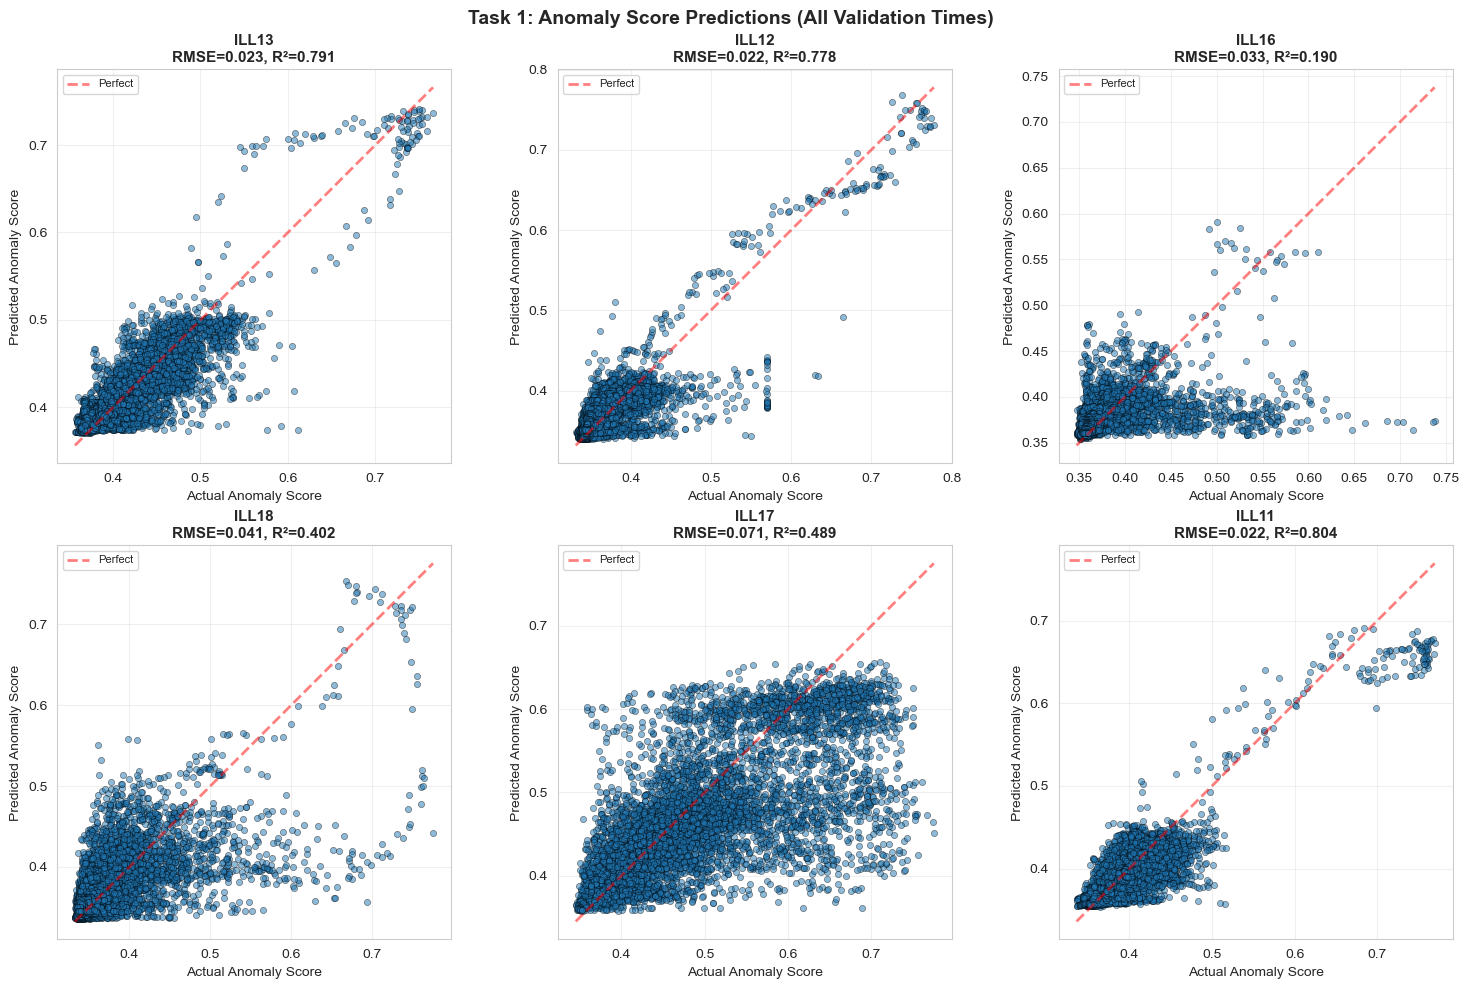

In [20]:
# Scatter plots for each station (all validation times)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, station in enumerate(all_stations):
    ax = axes[i]
    
    ax.scatter(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i], 
               alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    lims = [
        min(actuals_scores_val_unscaled[:, i].min(), predictions_scores_val_unscaled[:, i].min()),
        max(actuals_scores_val_unscaled[:, i].max(), predictions_scores_val_unscaled[:, i].max())
    ]
    ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect')
    
    # Metrics
    rmse_st = np.sqrt(mean_squared_error(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i]))
    r2_st = r2_score(actuals_scores_val_unscaled[:, i], predictions_scores_val_unscaled[:, i])
    
    ax.set_xlabel('Actual Anomaly Score', fontsize=10)
    ax.set_ylabel('Predicted Anomaly Score', fontsize=10)
    ax.set_title(f'{station}\nRMSE={rmse_st:.3f}, R²={r2_st:.3f}', 
                fontsize=11, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')

plt.suptitle('Task 1: Anomaly Score Predictions (All Validation Times)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('multitask_task1_scatter_all.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: multitask_task1_scatter_all.png")
plt.show()

  ✓ Saved: multitask_task1_scatter_debris_flow.png


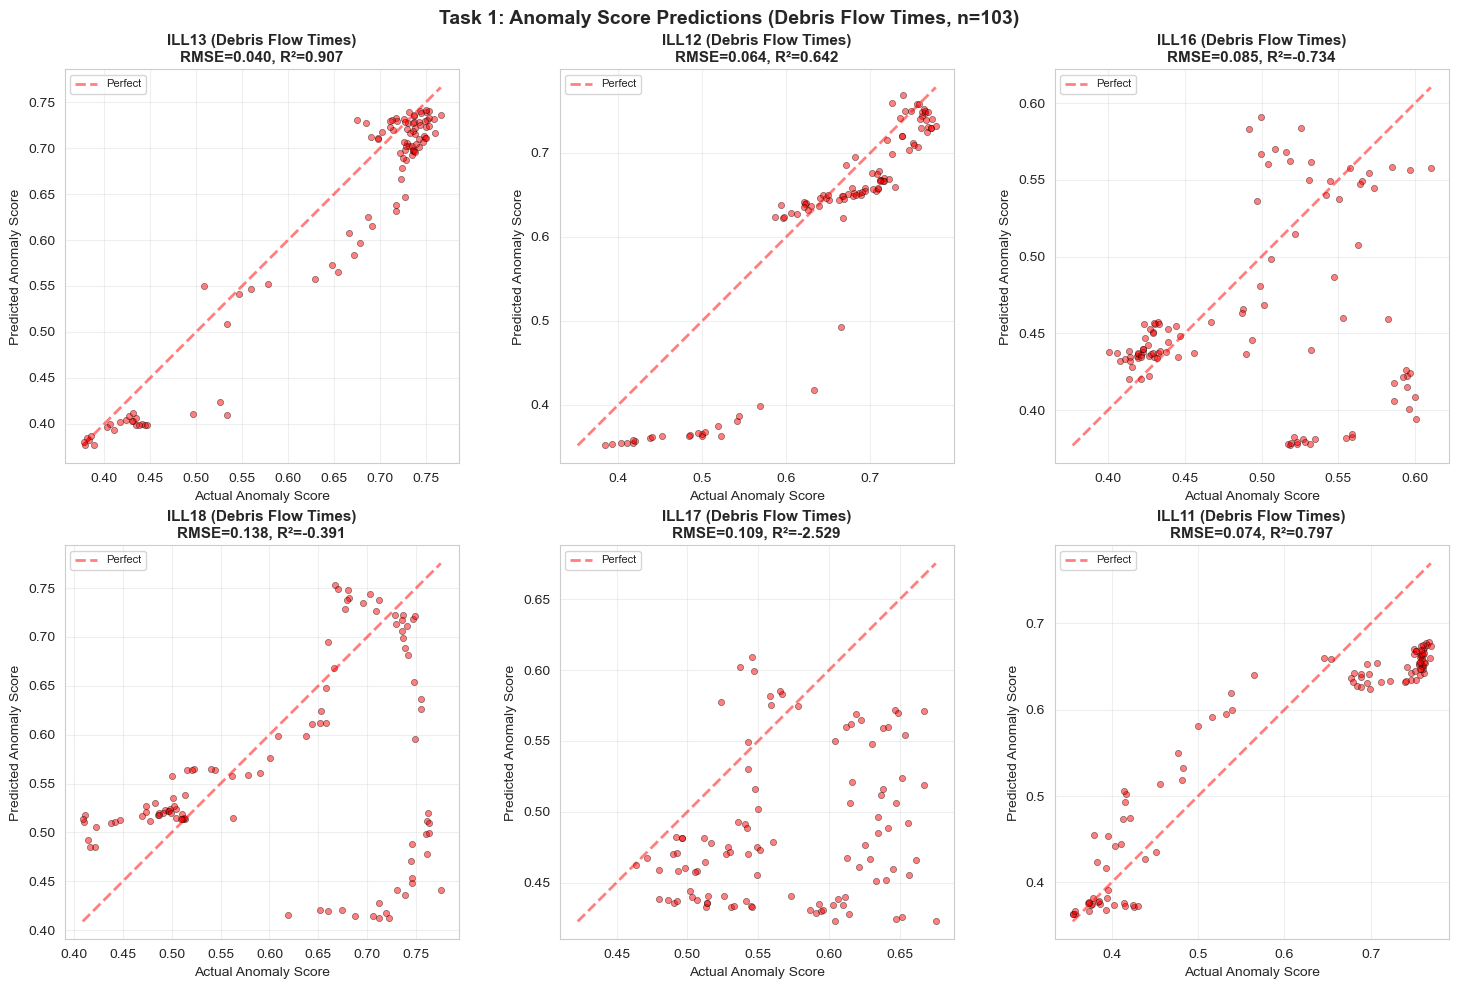

In [21]:
if debris_mask.sum() > 0:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, station in enumerate(all_stations):
        ax = axes[i]
        
        actual_debris = actuals_scores_val_unscaled[debris_mask, i]
        pred_debris = predictions_scores_val_unscaled[debris_mask, i]
        
        ax.scatter(actual_debris, pred_debris, 
                   alpha=0.5, s=20, edgecolors='black', linewidth=0.5, color='red')
        
        # Perfect prediction line
        lims = [
            min(actual_debris.min(), pred_debris.min()),
            max(actual_debris.max(), pred_debris.max())
        ]
        ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect')
        
        # Metrics
        rmse_st = np.sqrt(mean_squared_error(actual_debris, pred_debris))
        r2_st = r2_score(actual_debris, pred_debris)
        
        ax.set_xlabel('Actual Anomaly Score', fontsize=10)
        ax.set_ylabel('Predicted Anomaly Score', fontsize=10)
        ax.set_title(f'{station} (Debris Flow Times)\nRMSE={rmse_st:.3f}, R²={r2_st:.3f}', 
                    fontsize=11, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(alpha=0.3)
        ax.set_aspect('equal')
    
    plt.suptitle(f'Task 1: Anomaly Score Predictions (Debris Flow Times, n={debris_mask.sum()})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('multitask_task1_scatter_debris_flow.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: multitask_task1_scatter_debris_flow.png")
    plt.show()


  ✓ Saved: multitask_task2_detection.png


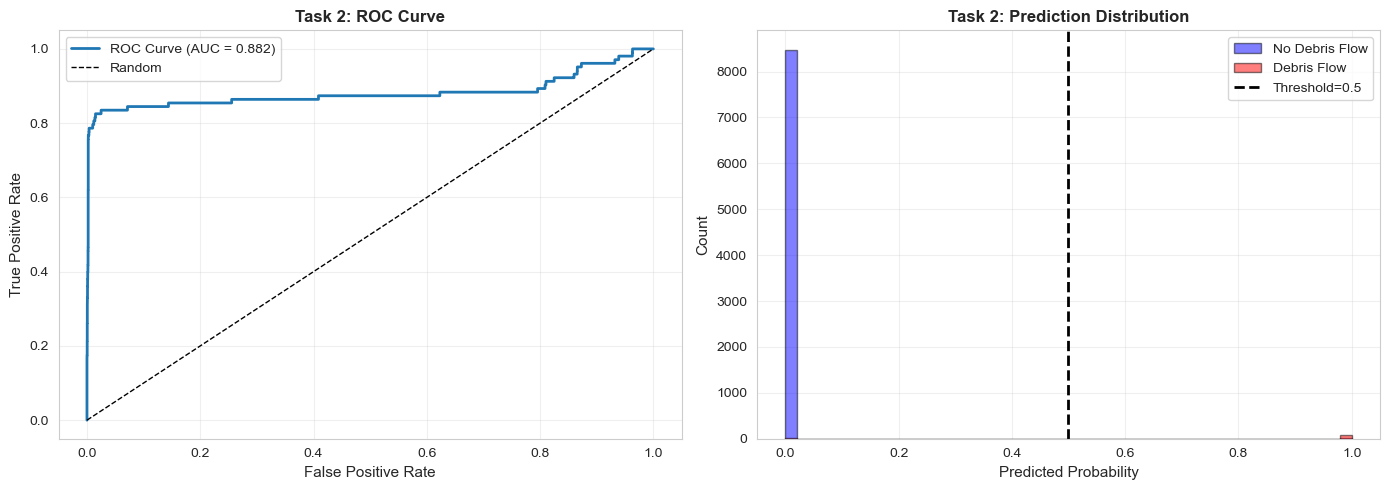

In [22]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
ax = axes[0]
fpr, tpr, thresholds = roc_curve(actuals_active_val, predictions_active_val)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('Task 2: ROC Curve', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

# Prediction histogram
ax = axes[1]
ax.hist(predictions_active_val[actuals_active_val == 0], bins=50, alpha=0.5, 
        label='No Debris Flow', color='blue', edgecolor='black')
ax.hist(predictions_active_val[actuals_active_val == 1], bins=50, alpha=0.5, 
        label='Debris Flow', color='red', edgecolor='black')
ax.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Task 2: Prediction Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('multitask_task2_detection.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: multitask_task2_detection.png")
plt.show()

  ✓ Saved: multitask_task3_confusion_matrix.png


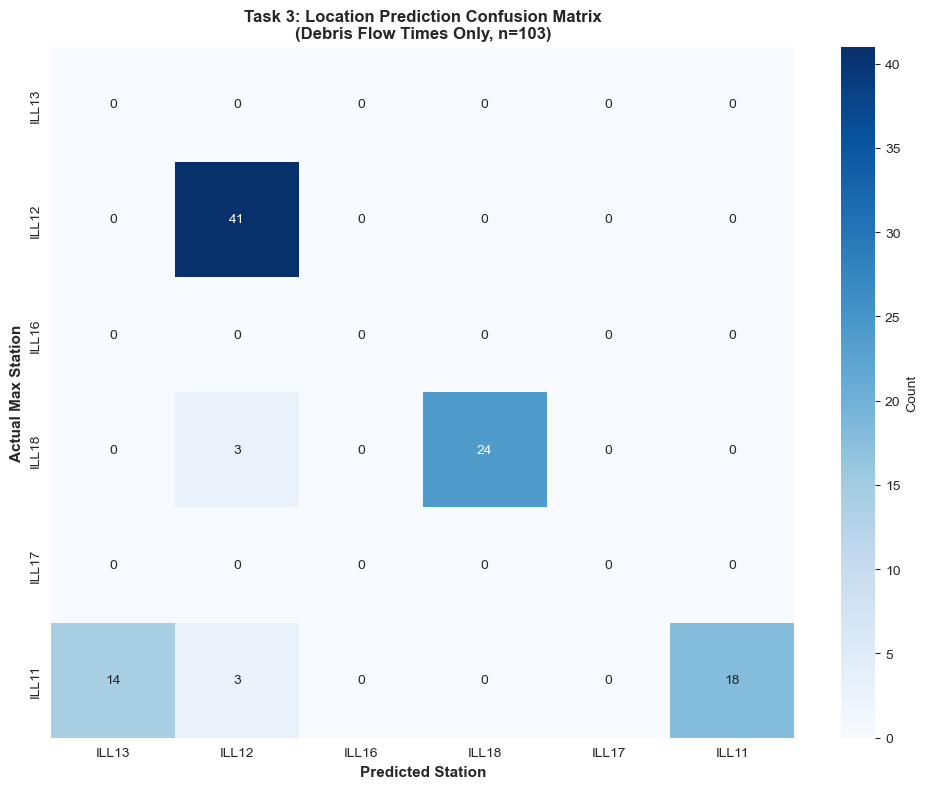

In [23]:

if debris_mask.sum() > 0:
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Confusion matrix for location predictions (debris flow times only)
    cm_location = confusion_matrix(actuals_location_val[debris_mask], 
                                    predictions_location_class[debris_mask],
                                    labels=range(len(all_stations)))
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    sns.heatmap(cm_location, annot=True, fmt='d', cmap='Blues', 
                xticklabels=all_stations, yticklabels=all_stations,
                cbar_kws={'label': 'Count'}, ax=ax)
    
    ax.set_xlabel('Predicted Station', fontsize=11, fontweight='bold')
    ax.set_ylabel('Actual Max Station', fontsize=11, fontweight='bold')
    ax.set_title(f'Task 3: Location Prediction Confusion Matrix\n(Debris Flow Times Only, n={debris_mask.sum()})', 
                fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('multitask_task3_confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: multitask_task3_confusion_matrix.png")
    plt.show()

  ✓ Saved: multitask_timeseries_all_tasks.png


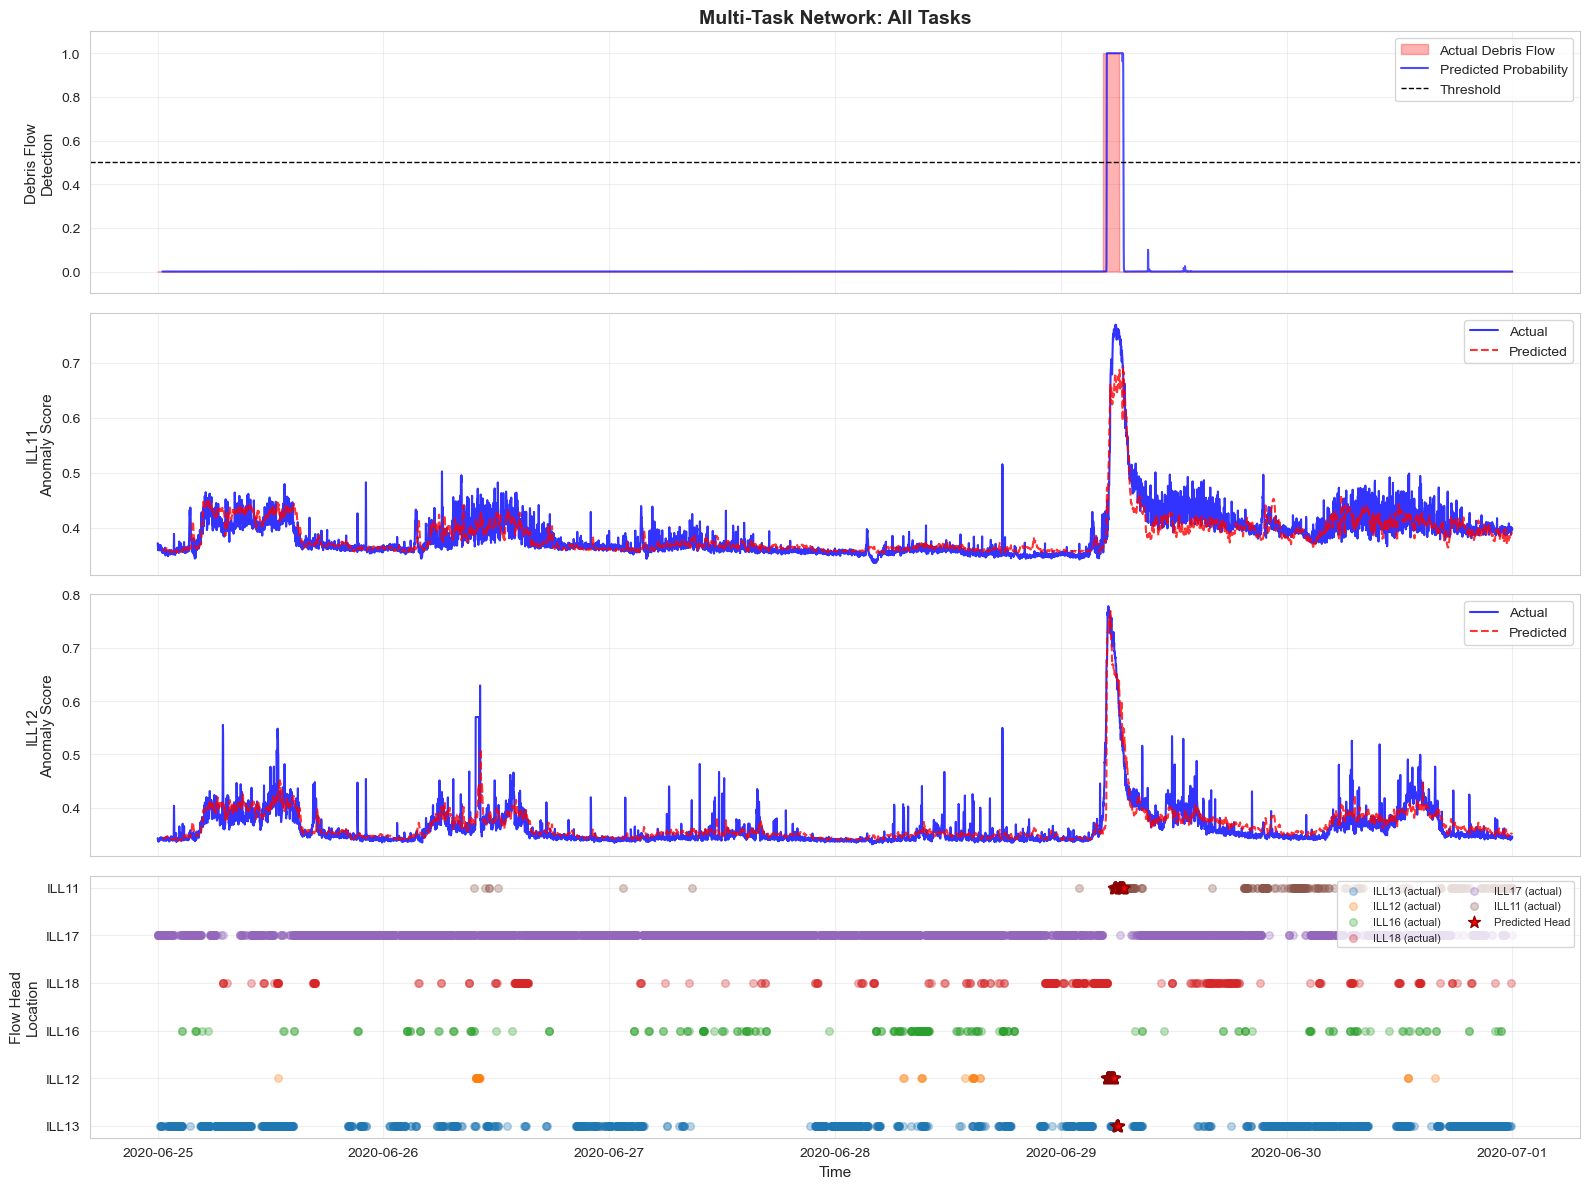

In [24]:

# Get full predictions for entire validation period
model.eval()
predictions_full_scores = np.zeros((len(data_scaled_val), len(all_stations)))
predictions_full_active = np.zeros(len(data_scaled_val))
predictions_full_location = np.zeros(len(data_scaled_val), dtype=int)

predictions_full_scores[:] = np.nan
predictions_full_active[:] = np.nan
predictions_full_location[:] = -1

with torch.no_grad():
    for i in range(lookback_start, len(data_scaled_val)):
        input_window = data_scaled_val[i - lookback_start : i - lookback_end]
        input_tensor = torch.FloatTensor(input_window).unsqueeze(0)
        
        pred_scores, pred_active_logits, pred_location_logits = model(input_tensor)
        
        pred_active_prob = torch.sigmoid(pred_active_logits)
        pred_location_probs = torch.softmax(pred_location_logits, dim=1)
        
        predictions_full_scores[i] = pred_scores.numpy().flatten()
        predictions_full_active[i] = pred_active_prob.item()
        predictions_full_location[i] = torch.argmax(pred_location_probs).item()

# Un-standardize scores
predictions_full_scores_unscaled = predictions_full_scores * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN
actual_val_full = data_scaled_val * FROZEN_SCALER_STD + FROZEN_SCALER_MEAN

# Get validation time indices
val_times = df_wide_all_filled.index[temporal_split_idx:]

# Plot
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)

# Panel 1: Debris flow indicator and detection
ax = axes[0]
ax.fill_between(val_times, 0, debris_val, alpha=0.3, color='red', label='Actual Debris Flow')
ax.plot(val_times, predictions_full_active, 'b-', linewidth=1.5, alpha=0.7, label='Predicted Probability')
ax.axhline(0.5, color='black', linestyle='--', linewidth=1, label='Threshold')
ax.set_ylabel('Debris Flow\nDetection', fontsize=11)
ax.set_ylim([-0.1, 1.1])
ax.legend(loc='upper right')
ax.set_title('Multi-Task Network: All Tasks', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

# Panel 2: Example station anomaly scores (ILL11)
ax = axes[1]
station_idx = all_stations.index('ILL11')
ax.plot(val_times, actual_val_full[:, station_idx], 'b-', linewidth=1.5, alpha=0.8, label='Actual')
ax.plot(val_times, predictions_full_scores_unscaled[:, station_idx], 'r--', linewidth=1.5, alpha=0.8, label='Predicted')
ax.set_ylabel('ILL11\nAnomaly Score', fontsize=11)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Panel 3: Another example station (ILL12)
ax = axes[2]
station_idx = all_stations.index('ILL12')
ax.plot(val_times, actual_val_full[:, station_idx], 'b-', linewidth=1.5, alpha=0.8, label='Actual')
ax.plot(val_times, predictions_full_scores_unscaled[:, station_idx], 'r--', linewidth=1.5, alpha=0.8, label='Predicted')
ax.set_ylabel('ILL12\nAnomaly Score', fontsize=11)
ax.legend(loc='upper right')
ax.grid(alpha=0.3)

# Panel 4: Flow head location
ax = axes[3]
# Show actual max station
actual_max_stations = np.argmax(actual_val_full, axis=1)
for i, station in enumerate(all_stations):
    mask = actual_max_stations == i
    if mask.sum() > 0:
        ax.scatter(val_times[mask], np.ones(mask.sum()) * i, 
                  alpha=0.3, s=30, label=f'{station} (actual)')

# Show predicted location (only when debris flow detected)
detected_mask = predictions_full_active > 0.5
if detected_mask.sum() > 0:
    pred_locations_detected = predictions_full_location[detected_mask]
    times_detected = val_times[detected_mask]
    ax.scatter(times_detected, pred_locations_detected, 
              color='red', s=80, marker='*', edgecolors='darkred', 
              linewidth=1, label='Predicted Head', zorder=10)

ax.set_yticks(range(len(all_stations)))
ax.set_yticklabels(all_stations)
ax.set_ylabel('Flow Head\nLocation', fontsize=11)
ax.set_xlabel('Time', fontsize=11)
ax.legend(loc='upper right', ncol=2, fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('multitask_timeseries_all_tasks.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: multitask_timeseries_all_tasks.png")
plt.show()


  Creating animation with 108 frames...
  Saving animation (this may take a minute)...


MovieWriter ffmpeg unavailable; using Pillow instead.


  ✓ Saved: multitask_flow_head_animation.gif
  ⚠ Could not save MP4: unknown file extension: .mp4


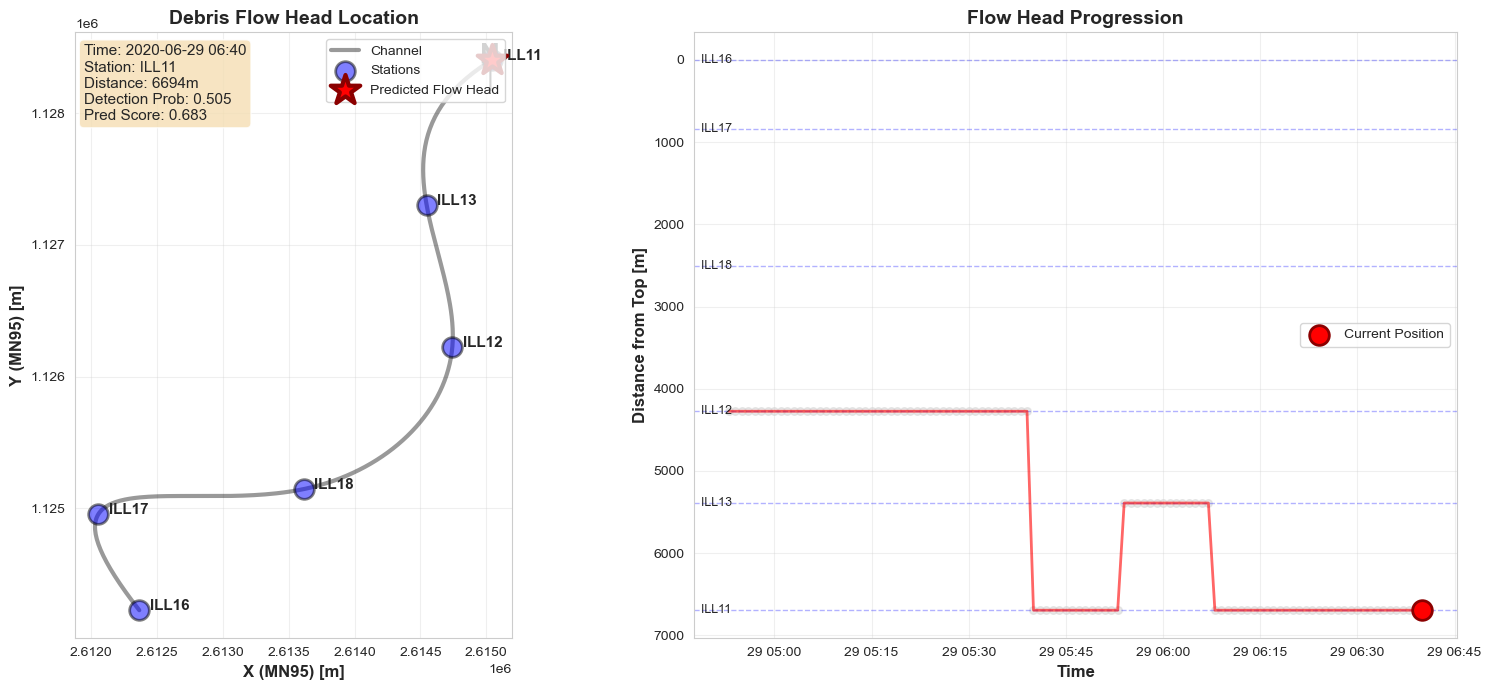


  Animation complete!
  Frames: 108
  Duration: ~21.6 seconds at 5 fps


In [25]:

# Get station coordinates
station_coords = (df_june.groupby('station')
                  .agg({
                      'X_mn95': 'first',
                      'Y_mn95': 'first',
                      'Elevation': 'first'
                  })
                  .reset_index())

# Filter to our stations
station_coords = station_coords[station_coords['station'].isin(all_stations)]

# Create channel centerline
from scipy.interpolate import splprep, splev

def create_channel_points_simple(station_coords, spacing=25):
    """Create interpolated points along channel."""
    stations_sorted = station_coords.sort_values('Elevation', ascending=False).reset_index(drop=True)
    
    tck, u = splprep(
        [stations_sorted['X_mn95'].values, 
         stations_sorted['Y_mn95'].values, 
         stations_sorted['Elevation'].values],
        s=0,
        k=min(3, len(stations_sorted)-1)
    )
    
    u_samples = np.linspace(0, 1, 100)
    x_samples, y_samples, z_samples = splev(u_samples, tck)
    path_length = np.sum(np.sqrt(
        np.diff(x_samples)**2 + np.diff(y_samples)**2 + np.diff(z_samples)**2
    ))
    
    n_points = max(int(path_length / spacing), len(stations_sorted))
    u_fine = np.linspace(0, 1, n_points)
    X_channel, Y_channel, Z_channel = splev(u_fine, tck)
    
    distances = np.zeros(n_points)
    for i in range(1, n_points):
        distances[i] = distances[i-1] + np.sqrt(
            (X_channel[i] - X_channel[i-1])**2 + 
            (Y_channel[i] - Y_channel[i-1])**2 +
            (Z_channel[i] - Z_channel[i-1])**2
        )
    
    return pd.DataFrame({
        'X': X_channel,
        'Y': Y_channel,
        'Z': Z_channel,
        'distance_from_top': distances
    })

channel_points = create_channel_points_simple(station_coords, spacing=25)

# Map stations to distance
station_to_distance = {}
for _, station_row in station_coords.iterrows():
    station = station_row['station']
    station_point = station_row[['X_mn95', 'Y_mn95']].values
    
    distances_to_channel = np.sqrt(
        (channel_points['X'] - station_point[0])**2 +
        (channel_points['Y'] - station_point[1])**2
    )
    nearest_idx = distances_to_channel.argmin()
    station_to_distance[station] = channel_points.loc[nearest_idx, 'distance_from_top']

station_coords['distance_from_top'] = station_coords['station'].map(station_to_distance)
station_coords = station_coords.sort_values('distance_from_top')

# Filter to detected debris flow times
detected_times_mask = (predictions_full_active > 0.5) & (~np.isnan(predictions_full_active))
detected_times_idx = np.where(detected_times_mask)[0]

if len(detected_times_idx) > 0:
    print(f"  Creating animation with {len(detected_times_idx)} frames...")
    
    # Set up figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # LEFT PANEL: Spatial map
    ax1.plot(channel_points['X'], channel_points['Y'], 'k-', 
            linewidth=3, alpha=0.4, label='Channel', zorder=1)
    
    # Plot all stations
    station_scatter = ax1.scatter(
        station_coords['X_mn95'], 
        station_coords['Y_mn95'],
        s=200, c='blue', alpha=0.5, 
        edgecolors='black', linewidth=2,
        label='Stations', zorder=2
    )
    
    # Add station labels
    for _, row in station_coords.iterrows():
        ax1.text(row['X_mn95'] + 80, row['Y_mn95'], row['station'], 
                fontsize=11, fontweight='bold')
    
    # Flow head marker (will be updated)
    flow_head = ax1.scatter([], [], s=500, c='red', marker='*', 
                           edgecolors='darkred', linewidth=3,
                           label='Predicted Flow Head', zorder=4)
    
    ax1.set_xlabel('X (MN95) [m]', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Y (MN95) [m]', fontsize=12, fontweight='bold')
    ax1.set_title('Debris Flow Head Location', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(alpha=0.3)
    ax1.set_aspect('equal')
    
    # Add north arrow
    ax1.annotate('N', xy=(0.95, 0.95), xycoords='axes fraction',
                fontsize=20, fontweight='bold', ha='center')
    ax1.annotate('↑', xy=(0.95, 0.92), xycoords='axes fraction',
                fontsize=30, ha='center')
    
    # Time and info text
    time_text = ax1.text(0.02, 0.98, '', transform=ax1.transAxes,
                        fontsize=11, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # RIGHT PANEL: Distance-time plot
    # Plot all detected points in gray
    detected_distances = []
    detected_times_plot = []
    for idx in detected_times_idx:
        pred_station_idx = predictions_full_location[idx]
        if pred_station_idx >= 0:
            station_name = all_stations[pred_station_idx]
            distance = station_coords[station_coords['station'] == station_name]['distance_from_top'].values[0]
            detected_distances.append(distance)
            detected_times_plot.append(val_times[idx])
    
    ax2.scatter(detected_times_plot, detected_distances,
               c='lightgray', s=30, alpha=0.5, zorder=1)
    
    # Add station reference lines
    for _, row in station_coords.iterrows():
        ax2.axhline(row['distance_from_top'], color='blue', 
                   linestyle='--', alpha=0.3, linewidth=1)
        ax2.text(ax2.get_xlim()[0], row['distance_from_top'], 
                f"  {row['station']}", fontsize=9, va='center')
    
    # Current position marker (will be updated)
    current_pos = ax2.scatter([], [], s=200, c='red', marker='o',
                             edgecolors='darkred', linewidth=2,
                             zorder=3, label='Current Position')
    
    # Trail (will be updated)
    trail_line, = ax2.plot([], [], 'r-', linewidth=2, alpha=0.6, zorder=2)
    
    ax2.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Distance from Top [m]', fontsize=12, fontweight='bold')
    ax2.set_title('Flow Head Progression', fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(alpha=0.3)
    ax2.invert_yaxis()
    
    plt.tight_layout()
    
    # Animation function
    def animate(frame):
        idx = detected_times_idx[frame]
        time = val_times[idx]
        
        # Get predicted location
        pred_station_idx = predictions_full_location[idx]
        if pred_station_idx >= 0:
            pred_station = all_stations[pred_station_idx]
            station_info = station_coords[station_coords['station'] == pred_station].iloc[0]
            
            # Update flow head position on map
            flow_head.set_offsets([[station_info['X_mn95'], station_info['Y_mn95']]])
            
            # Get predicted scores and probability
            pred_prob = predictions_full_active[idx]
            pred_scores_frame = predictions_full_scores_unscaled[idx]
            
            # Update time text
            time_text.set_text(f"Time: {time.strftime('%Y-%m-%d %H:%M')}\n"
                              f"Station: {pred_station}\n"
                              f"Distance: {station_info['distance_from_top']:.0f}m\n"
                              f"Detection Prob: {pred_prob:.3f}\n"
                              f"Pred Score: {pred_scores_frame[pred_station_idx]:.3f}")
            
            # Update current position on distance-time plot
            current_pos.set_offsets([[time, station_info['distance_from_top']]])
            
            # Update trail
            trail_times = detected_times_plot[:frame+1]
            trail_dists = detected_distances[:frame+1]
            trail_line.set_data(trail_times, trail_dists)
        
        return flow_head, time_text, current_pos, trail_line
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=len(detected_times_idx),
        interval=200,
        blit=True, repeat=True
    )
    
    # Save animation
    print("  Saving animation (this may take a minute)...")
    anim.save('multitask_flow_head_animation.gif', writer='pillow', fps=5, dpi=100)
    print("  ✓ Saved: multitask_flow_head_animation.gif")
    
    try:
        anim.save('multitask_flow_head_animation.mp4', writer='ffmpeg', fps=5, dpi=150)
        print("  ✓ Saved: multitask_flow_head_animation.mp4")
    except Exception as e:
        print(f"  ⚠ Could not save MP4: {e}")
    
    plt.show()

    print(f"\n  Animation complete!")
    print(f"  Frames: {len(detected_times_idx)}")
    print(f"  Duration: ~{len(detected_times_idx)/5:.1f} seconds at 5 fps")
else:
    print("  ⚠️  No detected debris flows - cannot create animation")
